In [4]:
import pydst
import pandas as pd
import numpy as np

In [5]:
Dst = pydst.Dst(lang='da')

In [6]:
FRDK118 = Dst.get_data(table_id = 'FRDK118', variables={"KØN" : ["*"], "ALDER" : ["*"], "TID" :["*"], "HERKOMST" : ["*"]})

In [7]:
FRDK118grouped = FRDK118.groupby(["KØN", "ALDER", "TID"])

In [8]:
FRDK118sum = FRDK118grouped.agg("sum").reset_index()

In [9]:
import os

FOLK2 = None
if os.path.isfile("FOLK2.pickle"):
    # if a pickle exists, unpickle it
    FOLK2 = pd.read_pickle("FOLK2.pickle")
else:
    # otherwise, fetch data and save as pickle
    FOLK2 = Dst.get_data(table_id = 'FOLK2', variables={"KØN" : ["*"],
                                                    "ALDER" : ["*"], 
                                                    "TID" :["*"], 
                                                    "HERKOMST" : ["*"], 
                                                    "STATSB" : ["*"],
                                                    "IELAND" : ["*"]})
    FOLK2.to_pickle("FOLK2.pickle")

In [10]:
FOLK2 = FOLK2[FOLK2["TID"] != 2019]

In [11]:
FOLK2grouped = FOLK2.groupby(["KØN", "ALDER", "TID"])
FOLK2sum = FOLK2grouped.agg("sum").reset_index()

In [12]:
FOLK2 = FOLK2.sort_values(by=["ALDER", "TID"])

In [13]:
both_outer = pd.merge(FRDK118sum, FOLK2sum, how='outer', on=["KØN", "ALDER", "TID", "INDHOLD"])

In [14]:

both_outer["ALDER"] = both_outer["ALDER"].apply(lambda alder : int(alder.replace(" år", "")))

In [15]:
x = both_outer.sort_values(by=["ALDER", "TID"])

In [16]:
only_men = both_outer[both_outer["KØN"] == 'Mænd']
only_women = both_outer[both_outer["KØN"] == 'Kvinder']

In [17]:
only_men = only_men.sort_values(by=['ALDER', 'TID'])
only_women = only_women.sort_values(by=['ALDER','TID'])

In [18]:
men1980 = np.array(only_men[only_men["TID"] == 1980]["INDHOLD"].tolist())
women1980 = np.array(only_women[only_women["TID"] == 1980]["INDHOLD"].tolist())

In [19]:
year_to_pop = {}
for i in range(1980,np.max(both_outer['TID'])+1):
    year = str(i)
    men = np.array(only_men[only_men["TID"] == i]["INDHOLD"].tolist())
    women = np.array(only_women[only_women["TID"] == i]["INDHOLD"].tolist())
    year_to_pop[year] = (men, women)

In [20]:
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets


py.offline.init_notebook_mode(connected=True)

In [21]:
year_to_pop["2018"]

(array([31624, 32226, 30524, 30231, 29754, 31183, 31402, 33940, 33872,
        35294, 34533, 35009, 34244, 34391, 34394, 34265, 34837, 35837,
        35665, 36675, 38176, 38974, 40766, 41381, 40642, 41297, 39685,
        39988, 38737, 37639, 36313, 35720, 34477, 33344, 32373, 33208,
        32657, 34281, 34909, 35800, 35395, 36982, 39430, 38935, 38777,
        40415, 40222, 38291, 38293, 39705, 42104, 45140, 43458, 42473,
        41188, 38673, 37343, 37267, 35279, 35292, 34759, 34641, 33997,
        32641, 33043, 32027, 31310, 31509, 30873, 32304, 33731, 34378,
        32307, 29580, 26334, 24196, 20673, 19249, 17595, 16456, 14778,
        13194, 11594, 10195,  8885,  7634,  6670,  5658,  4841,  4100,
         3195,  2620,  1956,  1474,  1035,   690,   549,   359,   221,
          139,    57,    51,    16,    12,    11,     6,     1,     0]),
 array([30107, 30282, 28999, 28600, 28451, 29295, 30303, 32296, 31999,
        33097, 32820, 33146, 32925, 32876, 32753, 32349, 33364, 34278,
    

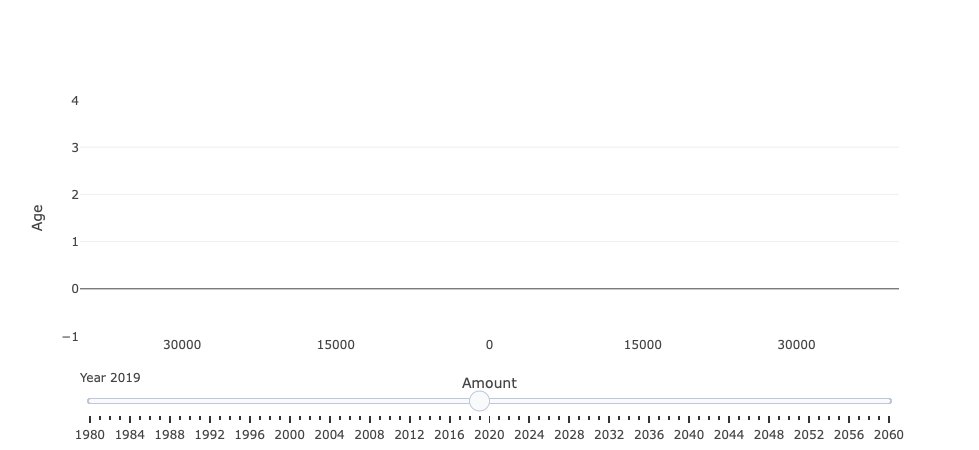

In [47]:
y = list(range(0, 120, 1))

lightblue = "#4bcffa"
darkblue = "#0fbcf9"
lightred = "#ef5777"
darkred = "#f53b57"

data = []

for year, (men, women) in year_to_pop.items():
    (men_inv, women_inv) = (men * -1, women * -1)
    data.extend([
        go.Bar(y=y,
               x=women_inv,
               visible = False,
               orientation='h',
               hoverinfo='none',
               showlegend=False,
               marker=dict(color=darkblue)
               ),
        go.Bar(y=y,
               visible = False,
               x=men_inv,
               orientation='h',
               name='Men',
               hoverinfo='x',
               marker=dict(color=lightblue)
               ),
        go.Bar(y=y,
               x=men,
               visible = False,
               orientation='h',
               showlegend=False,
               hoverinfo='none',
               marker=dict(color=darkred)
               ),
        go.Bar(y=y,
               x=women,
               visible = False,
               orientation='h',
               name='Women',
               hoverinfo='x',
               marker=dict(color=lightred)
               )
    ])
    
steps = []

for i in range(len(year_to_pop)):
    year = dict(
        method = "restyle",
        args = ["visible", [False] * len(year_to_pop) * 4],
        label=str(i + 1980)
    )
    year["args"][1][i*4 + 0] = True
    year["args"][1][i*4 + 1] = True
    year["args"][1][i*4 + 2] = True
    year["args"][1][i*4 + 3] = True
    steps.append(year)

sliders = [dict(
    active = 39,
    currentvalue = {"prefix": "Year "},
    pad = {"t": 30},
    steps = steps
)]

layout = dict(
    sliders = sliders,
    yaxis = go.layout.YAxis(title = "Age"),
    xaxis = go.layout.XAxis(
        range = [-40000, 40000],
        tickvals = [-45000, -30000, -15000, 0, 15000, 30000, 45000],
        ticktext = [45000, 30000, 15000, 0, 15000, 30000, 45000],
        title = "Amount"
    ),
    barmode = "overlay",
    bargap = 0.1
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [48]:


both_outer[(both_outer["ALDER"] < 16) & (both_outer["TID"] == 2010)].sum()["INDHOLD"]


1073864

In [49]:
both_outer[(both_outer["ALDER"] > 66) & (both_outer["TID"] == 2010)].sum()["INDHOLD"]

767510

In [50]:
both_outer[(both_outer["ALDER"] < 67) & (both_outer["ALDER"] > 15) & (both_outer["TID"] == 2010)].sum()["INDHOLD"]

3693364

In [51]:
FRKM118 = None
if os.path.isfile("FRKM118.pickle"):
    # if a pickle exists, unpickle it
    FRKM118 = pd.read_pickle("FRKM118.pickle")
else:
    # otherwise, fetch data and save as pickle
    FRKM118 = Dst.get_data(table_id = 'FRKM118', variables={"KØN" : ["*"],
                                                    "ALDER" : ["*"], 
                                                    "TID" :["*"], 
                                                    "OMRÅDE" : ["*"]})
    FRKM118.to_pickle("FRKM118.pickle")

In [63]:
FRKM118.rename(columns = {'OMRÅDE':'KOMK'}, inplace=True)
FRKM118 = FRKM118[FRKM118["ALDER"] != "Alder i alt"]

In [53]:
BY2 = None
if os.path.isfile("BY2.pickle"):
    # if a pickle exists, unpickle it
    BY2 = pd.read_pickle("BY2.pickle")
else:
    # otherwise, fetch data and save as pickle
    BY2 = Dst.get_data(table_id = "BY2", variables={"KØN" : ["*"],
                                                    "ALDER" : ["*"], 
                                                    "TID" :["*"],
                                                    "KOMK" : ["*"],
                                                    "BYST" : ["*"]})
    BY2.to_pickle("BY2.pickle")

In [54]:
BY2grouped = BY2.groupby(["KØN", "ALDER", "TID", "KOMK"])
BY2sum = BY2grouped.agg("sum").reset_index()

In [95]:
komk_outer = pd.merge(FRKM118, BY2sum, how='outer', on=["KØN", "ALDER", "TID", "INDHOLD", "KOMK"])

In [100]:
komk_outer["ALDER"] = komk_outer["ALDER"].apply(lambda alder : str(alder.replace( " år", "")))
komk_outer["ALDER"] = komk_outer["ALDER"].apply(lambda alder : int(alder.replace( " og derover", "")))

In [101]:
y = komk_outer.sort_values(by=["ALDER", "TID", "KOMK"])

In [102]:
y

,KØN,ALDER,TID,KOMK,INDHOLD
554288,Kvinder,0,2010,Aabenraa,300
635706,Mænd,0,2010,Aabenraa,331
554289,Kvinder,0,2010,Aalborg,1130
635707,Mænd,0,2010,Aalborg,1147
554290,Kvinder,0,2010,Aarhus,1870
635708,Mænd,0,2010,Aarhus,2004
554291,Kvinder,0,2010,Albertslund,143
635709,Mænd,0,2010,Albertslund,158
554292,Kvinder,0,2010,Allerød,126
635710,Mænd,0,2010,Allerød,104


In [90]:
xx = {}
for index, row in y[y["ALDER"] > 100].iterrows():
    year = row["TID"]
    gender = row["KØN"]
    xx[(year, gender)] = xx.get((year, gender), 0) + row["INDHOLD"]

In [91]:
xx

{(2010, 'Kvinder'): 452,
 (2010, 'Mænd'): 77,
 (2011, 'Kvinder'): 444,
 (2011, 'Mænd'): 71,
 (2012, 'Kvinder'): 434,
 (2012, 'Mænd'): 82,
 (2013, 'Kvinder'): 462,
 (2013, 'Mænd'): 85,
 (2014, 'Kvinder'): 506,
 (2014, 'Mænd'): 87,
 (2015, 'Kvinder'): 512,
 (2015, 'Mænd'): 94,
 (2016, 'Kvinder'): 536,
 (2016, 'Mænd'): 97,
 (2017, 'Kvinder'): 549,
 (2017, 'Mænd'): 89,
 (2018, 'Kvinder'): 564,
 (2018, 'Mænd'): 97}